# SUGD - Example Notebook with Outputs

This notebook differs slightly from the SUGD.ipynb prototype because it is corresponds to an earlier version and structure of the code but the functionality is exactly the same. Its purpose is to give an idea of the expected outputs while experimenting with the notebook.

## Imports

In [1]:
import warnings
import torch
import json
import gc

from peft import LoraConfig, get_peft_model, TaskType
from huggingface_hub import snapshot_download
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments
)
from utils.general import (
    DatasetProcessor,
    make_compute_metrics,
    preprocess_logits_for_metrics,
    print_number_of_trainable_model_parameters,
    print_gpu_memory,
    plot_metrics,
    plot_training_stats,
    QualitativeEvaluation,
    QuantitativeEvaluation
)
from utils.gradient_ascent_descent import (
    AscentPlusDescentDataCollator,
    SequentialUnlearning
)

warnings.filterwarnings('ignore')

## Load training parameters

In [2]:
output_dir = '/opt/ml/output/data'

# Load the training arguments from a json file
with open("sequential_args.json", 'r') as f:
    args = json.load(f)

# Store the training arguments in the output file for future reference
with open(f"{output_dir}/training_args.json", "w") as f:
    f.write(json.dumps(args, indent=4))

print(f"Sequential training with the following arguments:\n\n{json.dumps(args, indent=4)}")

Sequential training with the following arguments:

{
    "general": {
        "sequential": true,
        "chunk_size": 32,
        "split_retain": true,
        "positive_factor": 1,
        "positive_ratio": 3,
        "retain_loss": "CE",
        "split": "validation"
    },
    "training_args": {
        "per_device_batch_size": 16,
        "gradient_accumulation_steps": 1,
        "learning_rate": 5e-05,
        "num_epochs": 4
    },
    "model_params": {
        "model_size": "7B",
        "torch_dtype": "bfloat16",
        "apply_lora": true,
        "lora_r": 16,
        "lora_alpha": 32,
        "train_last_k": false,
        "k": 3
    }
}


## Load model and tokenizer

In [3]:
if args["model_params"]["model_size"] == "7B":
    model_repo_id = "llmunlearningsemeval2025organization/olmo-finetuned-semeval25-unlearning"
    tokenizer_path = "allenai/OLMo-7B-0724-Instruct-hf"
elif args["model_params"]["model_size"] == "1B":
    model_repo_id = "llmunlearningsemeval2025organization/olmo-1B-model-semeval25-unlearning"
    tokenizer_path = "allenai/OLMo-1B-0724-hf"

snapshot_download(repo_id=model_repo_id, local_dir='pretrained_model')

Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/10.0 [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

model-00001-of-00006.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00006.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00004-of-00006.safetensors:   0%|          | 0.00/4.86G [00:00<?, ?B/s]

model-00003-of-00006.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

model-00005-of-00006.safetensors:   0%|          | 0.00/4.86G [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/18.4k [00:00<?, ?B/s]

model-00006-of-00006.safetensors:   0%|          | 0.00/2.98G [00:00<?, ?B/s]

'/opt/ml/input/data/sagemaker_headless_execution_jupyterlab/pretrained_model'

In [4]:
base_model = AutoModelForCausalLM.from_pretrained('pretrained_model', device_map='auto', torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/5.73k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.12M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

In [5]:
print(print_number_of_trainable_model_parameters(base_model))

trainable model parameters: 6888095744
all model parameters: 6888095744
percentage of trainable model parameters: 100.00%


In [6]:
print_gpu_memory()


GPU 0: 3096.00 MB allocated
GPU 0: 3098.00 MB cached

GPU 1: 3474.00 MB allocated
GPU 1: 3476.00 MB cached

GPU 2: 3474.00 MB allocated
GPU 2: 3476.00 MB cached

GPU 3: 3096.00 MB allocated
GPU 3: 3098.00 MB cached


## Prepare Data

In [7]:
# Initialize
processor = DatasetProcessor(data_dir='semeval25-unlearning-data/data', tokenizer=tokenizer, n_samples_per_task=None)

# Construct the tokenized datasets as a DatasetDict
dataset = processor(split=args["general"]["split"], task='all', split_tasks=False, split_retain=False)

# Define the data collator
data_collator = AscentPlusDescentDataCollator(tokenizer=tokenizer, padding='longest', pad_to_multiple_of=8)

Map:   0%|          | 0/278 [00:00<?, ? examples/s]

Map:   0%|          | 0/254 [00:00<?, ? examples/s]

In [8]:
dataset

DatasetDict({
    retain: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 278
    })
    forget: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 254
    })
})

## Prepare model

In [9]:
if args["model_params"]["apply_lora"]:
    lora_config = LoraConfig(
        r=args["model_params"]["lora_r"], # Rank
        lora_alpha=args["model_params"]["lora_alpha"],
        target_modules=["q_proj", "v_proj", "up_proj", "down_proj"],
        bias="none",
        task_type=TaskType.CAUSAL_LM
    )

    peft_model = get_peft_model(base_model, lora_config)

In [10]:
print(print_number_of_trainable_model_parameters(peft_model))

trainable model parameters: 23855104
all model parameters: 6911950848
percentage of trainable model parameters: 0.35%


In [11]:
print_gpu_memory()


GPU 0: 3115.91 MB allocated
GPU 0: 3118.00 MB cached

GPU 1: 3499.60 MB allocated
GPU 1: 3502.00 MB cached

GPU 2: 3499.60 MB allocated
GPU 2: 3502.00 MB cached

GPU 3: 3115.91 MB allocated
GPU 3: 3118.00 MB cached


## Training Setup

In [12]:
training_args = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=args["training_args"]["per_device_batch_size"],
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=args["training_args"]["gradient_accumulation_steps"],
    eval_accumulation_steps=1,
    learning_rate=args["training_args"]["learning_rate"],
    num_train_epochs=args["training_args"]["num_epochs"],
    logging_steps=4,
    save_strategy="no",
    eval_strategy="epoch",
    fp16=True,
    report_to ="none",
    include_inputs_for_metrics=True
)

trainer = SequentialUnlearning(
    model=peft_model,
    tokenizer=tokenizer,
    data_collator=data_collator,
    training_args=training_args,
    forget_dataset=dataset['forget'],
    retain_dataset=dataset['retain'],
    compute_metrics=make_compute_metrics(peft_model, tokenizer, max_samples=32),
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,
    sequential=args["general"]["sequential"],
    chunk_size=args["general"]["chunk_size"],
    positive_ratio=args["general"]["positive_ratio"],
    positive_factor=args["general"]["positive_factor"],
    retain_loss=args["general"]["retain_loss"]
)

## Train

In [13]:
trainer.train(split_retain=args["general"]["split_retain"])


Training on chunk 1 ...


Filter:   0%|          | 0/96 [00:00<?, ? examples/s]

Filter:   0%|          | 0/96 [00:00<?, ? examples/s]

Filter:   0%|          | 0/96 [00:00<?, ? examples/s]

Filter:   0%|          | 0/32 [00:00<?, ? examples/s]

Filter:   0%|          | 0/32 [00:00<?, ? examples/s]

Filter:   0%|          | 0/32 [00:00<?, ? examples/s]


Chunk 1:
Train: {'retain_samples': 96, 'forget_samples': 32, 'total_samples': 128}

Eval: DatasetDict({
    retain_1: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 12
    })
    retain_2: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 54
    })
    retain_3: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 30
    })
    forget_1: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 6
    })
    forget_2: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 14
    })
    forget_3: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labe

Epoch,Training Loss,Validation Loss,Retain 1 Loss,Retain 1 Rougel,Retain 1 Em,Retain 2 Loss,Retain 2 Rougel,Retain 2 Em,Retain 3 Loss,Retain 3 Rougel,Retain 3 Em,Forget 1 Loss,Forget 1 Rougel,Forget 1 Em,Forget 2 Loss,Forget 2 Rougel,Forget 2 Em,Forget 3 Loss,Forget 3 Rougel,Forget 3 Em
1,0.000900,No log,0.001652,1.000000,1.000000,0.000903,1.000000,1.000000,0.000891,1.000000,1.000000,0.012285,1.000000,1.000000,0.033022,1.000000,0.818200,0.069040,0.950700,1.000000
2,-0.001800,No log,0.001506,1.000000,1.000000,0.000884,1.000000,1.000000,0.000824,1.000000,1.000000,0.159354,1.000000,0.666700,0.218291,1.000000,0.636400,0.239675,0.882900,0.800000
3,-0.044300,No log,0.001495,1.000000,1.000000,0.001038,1.000000,1.000000,0.000829,1.000000,1.000000,0.212400,0.882900,0.666700,0.365231,0.983300,0.545500,0.456540,0.801900,0.800000
4,-0.160500,No log,0.001501,1.000000,1.000000,0.001181,1.000000,1.000000,0.000845,1.000000,1.000000,0.242109,0.882900,0.666700,0.422157,0.983300,0.545500,0.553107,0.801900,0.800000


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)



Training on chunk 2 ...


Filter:   0%|          | 0/192 [00:00<?, ? examples/s]

Filter:   0%|          | 0/192 [00:00<?, ? examples/s]

Filter:   0%|          | 0/192 [00:00<?, ? examples/s]

Filter:   0%|          | 0/64 [00:00<?, ? examples/s]

Filter:   0%|          | 0/64 [00:00<?, ? examples/s]

Filter:   0%|          | 0/64 [00:00<?, ? examples/s]


Chunk 2:
Train: {'retain_samples': 96, 'forget_samples': 32, 'total_samples': 128}

Eval: DatasetDict({
    retain_1: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 38
    })
    retain_2: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 104
    })
    retain_3: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 50
    })
    forget_1: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 10
    })
    forget_2: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 36
    })
    forget_3: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'la

Epoch,Training Loss,Validation Loss,Retain 1 Loss,Retain 1 Rougel,Retain 1 Em,Retain 2 Loss,Retain 2 Rougel,Retain 2 Em,Retain 3 Loss,Retain 3 Rougel,Retain 3 Em,Forget 1 Loss,Forget 1 Rougel,Forget 1 Em,Forget 2 Loss,Forget 2 Rougel,Forget 2 Em,Forget 3 Loss,Forget 3 Rougel,Forget 3 Em
1,0.001300,No log,0.001399,1.000000,1.000000,0.001098,1.000000,1.000000,0.000961,1.000000,1.000000,0.145092,0.929700,0.800000,0.302008,0.907500,0.692300,0.337206,0.857900,0.875000
2,-0.044600,No log,0.001342,1.000000,1.000000,0.001824,1.000000,1.000000,0.001037,1.000000,1.000000,0.193448,0.884700,0.800000,0.568308,0.900500,0.592600,0.375749,0.816400,0.875000
3,-0.116600,No log,0.001404,1.000000,1.000000,0.004536,1.000000,1.000000,0.001218,1.000000,1.000000,0.240312,0.884700,0.800000,0.802712,0.915400,0.518500,0.426736,0.786000,0.875000
4,-0.181800,No log,0.001471,1.000000,1.000000,0.007161,0.992000,1.000000,0.001349,1.000000,1.000000,0.259477,0.884700,0.800000,0.944032,0.847600,0.481500,0.454157,0.786000,0.875000



Training on chunk 3 ...


Filter:   0%|          | 0/278 [00:00<?, ? examples/s]

Filter:   0%|          | 0/278 [00:00<?, ? examples/s]

Filter:   0%|          | 0/278 [00:00<?, ? examples/s]

Filter:   0%|          | 0/96 [00:00<?, ? examples/s]

Filter:   0%|          | 0/96 [00:00<?, ? examples/s]

Filter:   0%|          | 0/96 [00:00<?, ? examples/s]


Chunk 3:
Train: {'retain_samples': 96, 'forget_samples': 32, 'total_samples': 128}

Eval: DatasetDict({
    retain_1: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 54
    })
    retain_2: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 150
    })
    retain_3: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 74
    })
    forget_1: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 18
    })
    forget_2: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 54
    })
    forget_3: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'la

Epoch,Training Loss,Validation Loss,Retain 1 Loss,Retain 1 Rougel,Retain 1 Em,Retain 2 Loss,Retain 2 Rougel,Retain 2 Em,Retain 3 Loss,Retain 3 Rougel,Retain 3 Em,Forget 1 Loss,Forget 1 Rougel,Forget 1 Em,Forget 2 Loss,Forget 2 Rougel,Forget 2 Em,Forget 3 Loss,Forget 3 Rougel,Forget 3 Em
1,0.012700,No log,0.001571,1.000000,1.000000,0.001704,1.000000,1.000000,0.001693,1.000000,1.000000,0.135739,0.930000,0.888900,0.514769,0.943600,0.680000,0.300914,0.877000,0.909100
2,-0.000500,No log,0.001535,1.000000,1.000000,0.001700,1.000000,1.000000,0.001532,1.000000,1.000000,0.139663,0.923900,0.888900,0.595351,0.888100,0.642900,0.291070,0.885000,0.909100
3,-0.049400,No log,0.001575,1.000000,1.000000,0.002011,1.000000,1.000000,0.001584,1.000000,1.000000,0.164132,0.923900,0.888900,0.696726,0.859400,0.703700,0.297585,0.887700,0.909100
4,-0.082700,No log,0.001642,1.000000,1.000000,0.002303,1.000000,1.000000,0.001637,1.000000,1.000000,0.173100,0.923900,0.888900,0.745284,0.706100,0.586200,0.302671,0.889500,0.909100



Training on chunk 4 ...


Filter:   0%|          | 0/278 [00:00<?, ? examples/s]

Filter:   0%|          | 0/278 [00:00<?, ? examples/s]

Filter:   0%|          | 0/278 [00:00<?, ? examples/s]

Filter:   0%|          | 0/128 [00:00<?, ? examples/s]

Filter:   0%|          | 0/128 [00:00<?, ? examples/s]

Filter:   0%|          | 0/128 [00:00<?, ? examples/s]


Chunk 4:
Train: {'retain_samples': 96, 'forget_samples': 32, 'total_samples': 128}

Eval: DatasetDict({
    retain_1: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 54
    })
    retain_2: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 150
    })
    retain_3: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 74
    })
    forget_1: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 22
    })
    forget_2: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 72
    })
    forget_3: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'la

Epoch,Training Loss,Validation Loss,Retain 1 Loss,Retain 1 Rougel,Retain 1 Em,Retain 2 Loss,Retain 2 Rougel,Retain 2 Em,Retain 3 Loss,Retain 3 Rougel,Retain 3 Em,Forget 1 Loss,Forget 1 Rougel,Forget 1 Em,Forget 2 Loss,Forget 2 Rougel,Forget 2 Em,Forget 3 Loss,Forget 3 Rougel,Forget 3 Em
1,-0.000300,No log,0.001456,1.000000,1.000000,0.002866,1.000000,1.000000,0.001710,1.000000,1.000000,0.139678,0.937800,0.909100,0.641429,0.881900,0.583300,0.252555,0.869000,0.875000
2,-0.112700,No log,0.001614,1.000000,1.000000,0.012566,1.000000,1.000000,0.002381,1.000000,1.000000,0.149552,0.937800,0.909100,0.897507,0.876500,0.518500,0.379451,0.843400,0.875000
3,-0.302900,No log,0.002040,1.000000,1.000000,0.027515,1.000000,1.000000,0.004536,1.000000,1.000000,0.172478,0.935300,0.818200,1.113875,0.756300,0.458300,0.490512,0.850700,0.812500
4,-0.443800,No log,0.002415,1.000000,1.000000,0.035976,1.000000,0.963000,0.007260,0.950000,1.000000,0.185695,0.940200,0.818200,1.232034,0.700000,0.448300,0.558446,0.836000,0.750000



Training on chunk 5 ...


Filter:   0%|          | 0/278 [00:00<?, ? examples/s]

Filter:   0%|          | 0/278 [00:00<?, ? examples/s]

Filter:   0%|          | 0/278 [00:00<?, ? examples/s]

Filter:   0%|          | 0/160 [00:00<?, ? examples/s]

Filter:   0%|          | 0/160 [00:00<?, ? examples/s]

Filter:   0%|          | 0/160 [00:00<?, ? examples/s]


Chunk 5:
Train: {'retain_samples': 96, 'forget_samples': 32, 'total_samples': 128}

Eval: DatasetDict({
    retain_1: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 54
    })
    retain_2: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 150
    })
    retain_3: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 74
    })
    forget_1: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 32
    })
    forget_2: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 84
    })
    forget_3: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'la

Epoch,Training Loss,Validation Loss,Retain 1 Loss,Retain 1 Rougel,Retain 1 Em,Retain 2 Loss,Retain 2 Rougel,Retain 2 Em,Retain 3 Loss,Retain 3 Rougel,Retain 3 Em,Forget 1 Loss,Forget 1 Rougel,Forget 1 Em,Forget 2 Loss,Forget 2 Rougel,Forget 2 Em,Forget 3 Loss,Forget 3 Rougel,Forget 3 Em
1,0.054300,No log,0.003195,1.000000,1.000000,0.028396,0.963000,0.961500,0.007473,0.997400,1.000000,0.134372,0.958900,0.750000,1.301888,0.656800,0.423100,0.645668,0.810700,0.750000
2,-0.103900,No log,0.008532,1.000000,0.928600,0.063147,0.973300,0.931000,0.017949,0.944900,1.000000,0.161662,0.953800,0.687500,1.734456,0.709100,0.321400,1.034418,0.700400,0.750000
3,-0.391900,No log,0.023692,1.000000,1.000000,0.259777,0.780200,0.814800,0.068952,0.823600,1.000000,0.226152,0.933700,0.437500,2.414786,0.621000,0.360000,1.511137,0.751700,0.666700
4,-0.627300,No log,0.030629,0.990500,0.866700,0.365876,0.836200,0.814800,0.097394,0.915800,1.000000,0.264641,0.927600,0.375000,2.743583,0.452800,0.400000,1.728498,0.700900,0.600000



Training on chunk 6 ...


Filter:   0%|          | 0/278 [00:00<?, ? examples/s]

Filter:   0%|          | 0/278 [00:00<?, ? examples/s]

Filter:   0%|          | 0/278 [00:00<?, ? examples/s]

Filter:   0%|          | 0/192 [00:00<?, ? examples/s]

Filter:   0%|          | 0/192 [00:00<?, ? examples/s]

Filter:   0%|          | 0/192 [00:00<?, ? examples/s]


Chunk 6:
Train: {'retain_samples': 96, 'forget_samples': 32, 'total_samples': 128}

Eval: DatasetDict({
    retain_1: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 54
    })
    retain_2: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 150
    })
    retain_3: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 74
    })
    forget_1: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 34
    })
    forget_2: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 106
    })
    forget_3: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'l

Epoch,Training Loss,Validation Loss,Retain 1 Loss,Retain 1 Rougel,Retain 1 Em,Retain 2 Loss,Retain 2 Rougel,Retain 2 Em,Retain 3 Loss,Retain 3 Rougel,Retain 3 Em,Forget 1 Loss,Forget 1 Rougel,Forget 1 Em,Forget 2 Loss,Forget 2 Rougel,Forget 2 Em,Forget 3 Loss,Forget 3 Rougel,Forget 3 Em
1,-0.018600,No log,0.003810,1.000000,1.000000,0.080508,0.806000,0.923100,0.028683,0.947800,1.000000,0.271273,0.923100,0.437500,1.948419,0.499500,0.413800,1.231340,0.793300,0.937500
2,-0.393700,No log,0.026557,0.989200,0.764700,0.445286,0.745500,0.777800,0.119857,0.828500,0.937500,0.404272,0.884800,0.375000,3.005551,0.551200,0.307700,1.671629,0.693300,0.625000
3,-0.798800,No log,0.067867,0.991100,0.625000,0.803622,0.497000,0.480000,0.247595,0.751900,0.611100,0.559834,0.901900,0.250000,4.021673,0.330000,0.076900,2.103115,0.490300,0.615400
4,-1.283800,No log,0.071744,0.977700,0.571400,0.831133,0.401500,0.538500,0.272038,0.805300,0.600000,0.626412,0.852200,0.294100,4.384164,0.479300,0.076900,2.246360,0.512800,0.692300



Training on chunk 7 ...


Filter:   0%|          | 0/278 [00:00<?, ? examples/s]

Filter:   0%|          | 0/278 [00:00<?, ? examples/s]

Filter:   0%|          | 0/278 [00:00<?, ? examples/s]

Filter:   0%|          | 0/224 [00:00<?, ? examples/s]

Filter:   0%|          | 0/224 [00:00<?, ? examples/s]

Filter:   0%|          | 0/224 [00:00<?, ? examples/s]


Chunk 7:
Train: {'retain_samples': 96, 'forget_samples': 32, 'total_samples': 128}

Eval: DatasetDict({
    retain_1: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 54
    })
    retain_2: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 150
    })
    retain_3: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 74
    })
    forget_1: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 38
    })
    forget_2: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 130
    })
    forget_3: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'l

Epoch,Training Loss,Validation Loss,Retain 1 Loss,Retain 1 Rougel,Retain 1 Em,Retain 2 Loss,Retain 2 Rougel,Retain 2 Em,Retain 3 Loss,Retain 3 Rougel,Retain 3 Em,Forget 1 Loss,Forget 1 Rougel,Forget 1 Em,Forget 2 Loss,Forget 2 Rougel,Forget 2 Em,Forget 3 Loss,Forget 3 Rougel,Forget 3 Em
1,0.061800,No log,0.003613,0.991600,1.000000,0.035385,0.993800,1.000000,0.005999,0.992600,1.000000,0.300123,0.953800,0.562500,1.976273,0.554800,0.571400,1.256906,0.696800,0.800000
2,-0.531700,No log,0.002058,1.000000,1.000000,0.011542,0.986700,1.000000,0.003763,1.000000,1.000000,0.273654,0.949600,0.750000,1.967061,0.680200,0.461500,1.139331,0.634400,0.857100
3,-0.967500,No log,0.004387,0.990300,1.000000,0.036593,0.981500,1.000000,0.006629,1.000000,1.000000,0.308069,0.936700,0.625000,2.606546,0.680600,0.291700,1.317713,0.684400,0.750000
4,-1.250000,No log,0.006732,1.000000,1.000000,0.062338,0.964800,0.964300,0.009735,0.995100,1.000000,0.325043,0.914100,0.611100,2.982158,0.549100,0.320000,1.421188,0.674500,0.812500


Filter:   0%|          | 0/278 [00:00<?, ? examples/s]

Filter:   0%|          | 0/278 [00:00<?, ? examples/s]

Filter:   0%|          | 0/278 [00:00<?, ? examples/s]

Filter:   0%|          | 0/254 [00:00<?, ? examples/s]

Filter:   0%|          | 0/254 [00:00<?, ? examples/s]

Filter:   0%|          | 0/254 [00:00<?, ? examples/s]


Chunk 8:
Train: {'retain_samples': 90, 'forget_samples': 30, 'total_samples': 120}

Eval: DatasetDict({
    retain_1: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 54
    })
    retain_2: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 150
    })
    retain_3: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 74
    })
    forget_1: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 48
    })
    forget_2: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 138
    })
    forget_3: Dataset({
        features: ['id', 'input', 'output', 'task', 'split', 'input_ids', 'attention_mask', 'l

Epoch,Training Loss,Validation Loss,Retain 1 Loss,Retain 1 Rougel,Retain 1 Em,Retain 2 Loss,Retain 2 Rougel,Retain 2 Em,Retain 3 Loss,Retain 3 Rougel,Retain 3 Em,Forget 1 Loss,Forget 1 Rougel,Forget 1 Em,Forget 2 Loss,Forget 2 Rougel,Forget 2 Em,Forget 3 Loss,Forget 3 Rougel,Forget 3 Em
1,-0.057600,No log,0.004120,1.000000,1.000000,0.038605,0.977200,0.961500,0.014450,1.000000,1.000000,0.441245,0.913000,0.437500,2.506574,0.513800,0.423100,1.326429,0.529300,0.571400
2,-0.763200,No log,0.028700,0.994500,0.812500,0.153278,0.655300,0.827600,0.107262,0.881300,0.882400,0.797671,0.770300,0.210500,3.087219,0.451600,0.148100,1.910293,0.401300,0.578900
3,-1.604000,No log,0.071495,0.924500,0.600000,0.280066,0.804100,0.785700,0.236585,0.652700,0.750000,1.005505,0.785700,0.176500,3.604877,0.411200,0.178600,2.445143,0.395900,0.533300
4,-2.216600,No log,0.095157,0.903200,0.562500,0.356489,0.780900,0.750000,0.328980,0.621400,0.642900,1.160262,0.764200,0.266700,3.906661,0.414100,0.185200,2.771869,0.389000,0.375000


In [14]:
trainer.save_model()

Saving final model to /opt/ml/output/data/final_model


In [15]:
summary = trainer.save_summary(output_dir)

print(summary['total_runtime'])
print(summary['total_flos'])

9372.9904
4.164399605691187e+16


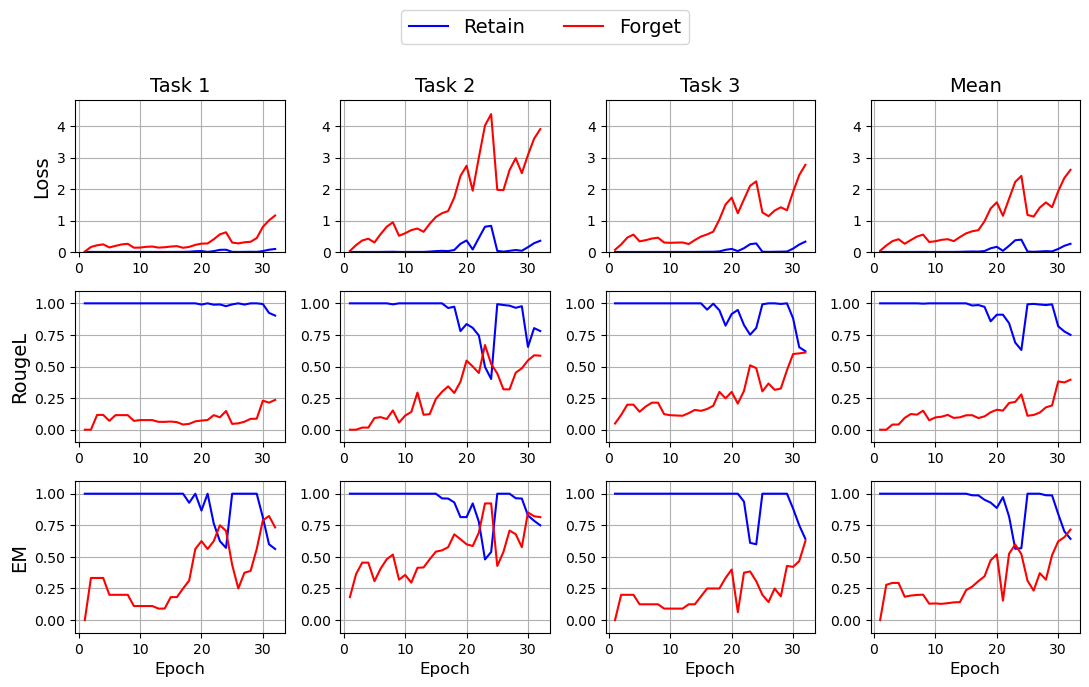

In [16]:
plot_metrics(summary["log_history"], output_dir)

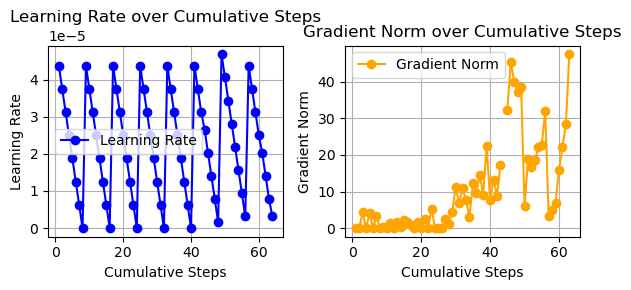

In [17]:
plot_training_stats(summary["log_history"])

In [18]:
peft_model.merge_and_unload()
print(peft_model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): OlmoForCausalLM(
      (model): OlmoModel(
        (embed_tokens): Embedding(50304, 4096, padding_idx=1)
        (layers): ModuleList(
          (0-31): 32 x OlmoDecoderLayer(
            (self_attn): OlmoSdpaAttention(
              (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
              (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
              (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
              (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
              (rotary_emb): OlmoRotaryEmbedding()
            )
            (mlp): OlmoMLP(
              (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
              (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
              (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
              (act_fn): SiLU()
            )
           

In [19]:
peft_model.model.save_pretrained("unlearned_model")
trainer.tokenizer.save_pretrained("unlearned_model")

('unlearned_model/tokenizer_config.json',
 'unlearned_model/special_tokens_map.json',
 'unlearned_model/tokenizer.json')

In [20]:
print_gpu_memory()


GPU 0: 3171.97 MB allocated
GPU 0: 3708.00 MB cached

GPU 1: 3567.04 MB allocated
GPU 1: 4174.00 MB cached

GPU 2: 3567.04 MB allocated
GPU 2: 4174.00 MB cached

GPU 3: 3171.97 MB allocated
GPU 3: 3762.00 MB cached


In [21]:
del trainer
del base_model
del peft_model

gc.collect()
torch.cuda.empty_cache()

In [22]:
print_gpu_memory()


GPU 0: 16.25 MB allocated
GPU 0: 120.00 MB cached

GPU 1: 16.25 MB allocated
GPU 1: 20.00 MB cached

GPU 2: 16.25 MB allocated
GPU 2: 20.00 MB cached

GPU 3: 16.25 MB allocated
GPU 3: 20.00 MB cached


## Final Evaluation

In [23]:
# Quantitative Evaluation

evaluation_args = {
    "seed": 42,
    "debug": True,
    "keep_files": True,
    "max_new_tokens": 256,
    "compute_metrics_only": False,
    "batch_size": 8,
    "mia_data_path": "semeval25-unlearning-data/mia_data/",
    "data_path": "semeval25-unlearning-data/data/",
    "checkpoint_path": "unlearned_model",
    "output_dir": f"{output_dir}/evaluation",
    "mmlu_metrics_file_path": None
}

quantitative_eval = QuantitativeEvaluation(evaluation_args)

In [24]:
quantitative_eval.run()

Evaluating Checkpoint at unlearned_model


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

  0%|          | 0/278 [00:00<?, ?it/s]

  0%|          | 1/278 [00:01<07:44,  1.68s/it]

  1%|          | 2/278 [00:01<03:28,  1.32it/s]

  1%|          | 3/278 [00:03<05:23,  1.18s/it]

  1%|▏         | 4/278 [00:03<03:26,  1.33it/s]

  2%|▏         | 5/278 [00:05<04:44,  1.04s/it]

  2%|▏         | 6/278 [00:05<03:57,  1.14it/s]

  3%|▎         | 7/278 [00:07<05:00,  1.11s/it]

  3%|▎         | 8/278 [00:07<03:39,  1.23it/s]

  3%|▎         | 9/278 [00:10<06:18,  1.41s/it]

  4%|▎         | 10/278 [00:10<04:40,  1.05s/it]

  4%|▍         | 11/278 [00:10<03:31,  1.27it/s]

  4%|▍         | 12/278 [00:10<02:43,  1.63it/s]

  5%|▍         | 13/278 [00:11<02:20,  1.88it/s]

  5%|▌         | 14/278 [00:11<02:27,  1.80it/s]

  5%|▌         | 15/278 [00:13<04:00,  1.09it/s]

  6%|▌         | 16/278 [00:13<03:25,  1.28it/s]

  6%|▌         | 17/278 [00:14<03:34,  1.22it/s]

  6%|▋         | 18/278 [00:15<03:28,  1.25it/s]

  7%|▋         | 19/278 [00:17<05:17,  1.23s/it]

  7%|▋         | 20/278 [00:18<04:00,  1.07it/s]

  8%|▊         | 21/278 [00:18<03:03,  1.40it/s]

  8%|▊         | 22/278 [00:18<02:26,  1.75it/s]

  8%|▊         | 23/278 [00:18<02:11,  1.95it/s]

  9%|▊         | 24/278 [00:20<02:54,  1.45it/s]

  9%|▉         | 25/278 [00:24<07:52,  1.87s/it]

  9%|▉         | 26/278 [00:24<05:48,  1.38s/it]

 10%|▉         | 27/278 [00:26<05:42,  1.36s/it]

 10%|█         | 28/278 [00:26<04:19,  1.04s/it]

 10%|█         | 29/278 [00:31<08:42,  2.10s/it]

 11%|█         | 30/278 [00:31<06:22,  1.54s/it]

 11%|█         | 31/278 [00:31<04:41,  1.14s/it]

 12%|█▏        | 32/278 [00:31<03:34,  1.15it/s]

 12%|█▏        | 33/278 [00:32<02:57,  1.38it/s]

 12%|█▏        | 34/278 [00:34<04:45,  1.17s/it]

 13%|█▎        | 35/278 [00:37<07:41,  1.90s/it]

 13%|█▎        | 36/278 [00:38<05:39,  1.40s/it]

 13%|█▎        | 37/278 [00:40<06:50,  1.70s/it]

 14%|█▎        | 38/278 [00:40<05:03,  1.27s/it]

 14%|█▍        | 39/278 [00:41<03:44,  1.07it/s]

 14%|█▍        | 40/278 [00:41<02:51,  1.39it/s]

 15%|█▍        | 41/278 [00:41<02:26,  1.62it/s]

 15%|█▌        | 42/278 [00:42<02:20,  1.68it/s]

 15%|█▌        | 43/278 [00:43<03:23,  1.15it/s]

 16%|█▌        | 44/278 [00:43<02:36,  1.49it/s]

 16%|█▌        | 45/278 [00:52<12:08,  3.13s/it]

 17%|█▋        | 46/278 [00:52<08:44,  2.26s/it]

 17%|█▋        | 47/278 [00:53<06:20,  1.65s/it]

 17%|█▋        | 48/278 [00:53<04:39,  1.21s/it]

 18%|█▊        | 49/278 [00:53<03:38,  1.05it/s]

 18%|█▊        | 50/278 [00:56<05:55,  1.56s/it]

 18%|█▊        | 51/278 [01:02<10:35,  2.80s/it]

 19%|█▊        | 52/278 [01:02<07:30,  1.99s/it]

 19%|█▉        | 53/278 [01:04<07:55,  2.12s/it]

 19%|█▉        | 54/278 [01:05<05:48,  1.55s/it]

 20%|█▉        | 55/278 [01:05<04:16,  1.15s/it]

 20%|██        | 56/278 [01:05<03:15,  1.14it/s]

 21%|██        | 57/278 [01:06<02:47,  1.32it/s]

 21%|██        | 58/278 [01:14<11:41,  3.19s/it]

 21%|██        | 59/278 [01:16<10:16,  2.81s/it]

 22%|██▏       | 60/278 [01:17<07:25,  2.04s/it]

 22%|██▏       | 61/278 [01:17<05:23,  1.49s/it]

 22%|██▏       | 62/278 [01:18<04:49,  1.34s/it]

 23%|██▎       | 63/278 [01:18<03:50,  1.07s/it]

 23%|██▎       | 64/278 [01:19<03:13,  1.10it/s]

 23%|██▎       | 65/278 [01:20<03:53,  1.09s/it]

 24%|██▎       | 66/278 [01:20<02:51,  1.24it/s]

 24%|██▍       | 67/278 [01:22<03:57,  1.13s/it]

 24%|██▍       | 68/278 [01:23<03:00,  1.16it/s]

 25%|██▍       | 69/278 [01:29<08:57,  2.57s/it]

 25%|██▌       | 70/278 [01:29<06:29,  1.87s/it]

 26%|██▌       | 71/278 [01:30<04:42,  1.36s/it]

 26%|██▌       | 72/278 [01:30<03:31,  1.03s/it]

 26%|██▋       | 73/278 [01:30<02:48,  1.22it/s]

 27%|██▋       | 74/278 [01:33<04:42,  1.38s/it]

 27%|██▋       | 75/278 [01:34<04:56,  1.46s/it]

 27%|██▋       | 76/278 [01:35<03:45,  1.12s/it]

 28%|██▊       | 77/278 [01:37<05:12,  1.56s/it]

 28%|██▊       | 78/278 [01:38<03:48,  1.14s/it]

 28%|██▊       | 79/278 [01:41<06:34,  1.98s/it]

 29%|██▉       | 80/278 [01:42<04:50,  1.47s/it]

 29%|██▉       | 81/278 [01:47<08:42,  2.65s/it]

 29%|██▉       | 82/278 [01:47<06:20,  1.94s/it]

 30%|██▉       | 83/278 [01:49<06:15,  1.93s/it]

 30%|███       | 84/278 [01:50<04:35,  1.42s/it]

 31%|███       | 85/278 [01:50<03:24,  1.06s/it]

 31%|███       | 86/278 [01:50<02:36,  1.23it/s]

 31%|███▏      | 87/278 [01:50<02:08,  1.49it/s]

 32%|███▏      | 88/278 [01:51<01:58,  1.60it/s]

 32%|███▏      | 89/278 [01:52<02:39,  1.18it/s]

 32%|███▏      | 90/278 [01:52<02:02,  1.53it/s]

 33%|███▎      | 91/278 [02:01<09:09,  2.94s/it]

 33%|███▎      | 92/278 [02:01<07:00,  2.26s/it]

 33%|███▎      | 93/278 [02:03<06:29,  2.11s/it]

 34%|███▍      | 94/278 [02:07<07:57,  2.59s/it]

 34%|███▍      | 95/278 [02:09<07:48,  2.56s/it]

 35%|███▍      | 96/278 [02:10<05:37,  1.85s/it]

 35%|███▍      | 97/278 [02:17<10:46,  3.57s/it]

 35%|███▌      | 98/278 [02:17<07:41,  2.56s/it]

 36%|███▌      | 99/278 [02:20<07:17,  2.44s/it]

 36%|███▌      | 100/278 [02:20<05:17,  1.78s/it]

 36%|███▋      | 101/278 [02:20<03:52,  1.31s/it]

 37%|███▋      | 102/278 [02:20<02:54,  1.01it/s]

 37%|███▋      | 103/278 [02:21<02:21,  1.24it/s]

 37%|███▋      | 104/278 [02:21<02:24,  1.20it/s]

 38%|███▊      | 105/278 [02:24<03:33,  1.23s/it]

 38%|███▊      | 106/278 [02:24<02:41,  1.07it/s]

 38%|███▊      | 107/278 [02:24<02:02,  1.39it/s]

 39%|███▉      | 108/278 [02:24<01:37,  1.74it/s]

 39%|███▉      | 109/278 [02:25<01:27,  1.94it/s]

 40%|███▉      | 110/278 [02:29<04:53,  1.75s/it]

 40%|███▉      | 111/278 [02:31<04:27,  1.60s/it]

 40%|████      | 112/278 [02:31<03:14,  1.17s/it]

 41%|████      | 113/278 [02:34<05:12,  1.89s/it]

 41%|████      | 114/278 [02:35<03:54,  1.43s/it]

 41%|████▏     | 115/278 [02:39<06:08,  2.26s/it]

 42%|████▏     | 116/278 [02:39<04:29,  1.67s/it]

 42%|████▏     | 117/278 [02:41<04:13,  1.57s/it]

 42%|████▏     | 118/278 [02:41<03:08,  1.18s/it]

 43%|████▎     | 119/278 [02:42<03:23,  1.28s/it]

 43%|████▎     | 120/278 [02:43<02:41,  1.02s/it]

 44%|████▎     | 121/278 [02:45<03:24,  1.30s/it]

 44%|████▍     | 122/278 [02:45<02:33,  1.02it/s]

 44%|████▍     | 123/278 [02:45<01:56,  1.33it/s]

 45%|████▍     | 124/278 [02:45<01:32,  1.67it/s]

 45%|████▍     | 125/278 [02:46<01:21,  1.88it/s]

 45%|████▌     | 126/278 [02:46<01:21,  1.86it/s]

 46%|████▌     | 127/278 [02:48<02:12,  1.14it/s]

 46%|████▌     | 128/278 [02:48<01:38,  1.52it/s]

 46%|████▋     | 129/278 [02:49<02:07,  1.17it/s]

 47%|████▋     | 130/278 [02:50<01:36,  1.53it/s]

 47%|████▋     | 131/278 [02:52<02:36,  1.07s/it]

 47%|████▋     | 132/278 [02:52<01:59,  1.22it/s]

 48%|████▊     | 133/278 [02:52<01:32,  1.57it/s]

 48%|████▊     | 134/278 [02:52<01:13,  1.97it/s]

 49%|████▊     | 135/278 [02:53<01:08,  2.09it/s]

 49%|████▉     | 136/278 [02:53<01:13,  1.92it/s]

 49%|████▉     | 137/278 [02:55<02:10,  1.08it/s]

 50%|████▉     | 138/278 [02:55<01:40,  1.39it/s]

 50%|█████     | 139/278 [02:57<02:10,  1.07it/s]

 50%|█████     | 140/278 [02:57<01:38,  1.41it/s]

 51%|█████     | 141/278 [03:00<03:03,  1.34s/it]

 51%|█████     | 142/278 [03:00<02:14,  1.01it/s]

 51%|█████▏    | 143/278 [03:02<02:41,  1.19s/it]

 52%|█████▏    | 144/278 [03:02<02:00,  1.11it/s]

 52%|█████▏    | 145/278 [03:06<03:50,  1.73s/it]

 53%|█████▎    | 146/278 [03:06<02:59,  1.36s/it]

 53%|█████▎    | 147/278 [03:08<03:27,  1.59s/it]

 53%|█████▎    | 148/278 [03:09<02:36,  1.21s/it]

 54%|█████▎    | 149/278 [03:10<02:49,  1.31s/it]

 54%|█████▍    | 150/278 [03:10<02:07,  1.01it/s]

 54%|█████▍    | 151/278 [03:12<02:43,  1.29s/it]

 55%|█████▍    | 152/278 [03:13<02:33,  1.22s/it]

 55%|█████▌    | 153/278 [03:15<03:00,  1.44s/it]

 55%|█████▌    | 154/278 [03:16<02:14,  1.08s/it]

 56%|█████▌    | 155/278 [03:16<01:40,  1.22it/s]

 56%|█████▌    | 156/278 [03:16<01:17,  1.57it/s]

 56%|█████▋    | 157/278 [03:16<01:07,  1.79it/s]

 57%|█████▋    | 158/278 [03:17<01:09,  1.74it/s]

 57%|█████▋    | 159/278 [03:19<01:49,  1.09it/s]

 58%|█████▊    | 160/278 [03:19<01:24,  1.40it/s]

 58%|█████▊    | 161/278 [03:19<01:06,  1.77it/s]

 58%|█████▊    | 162/278 [03:19<00:54,  2.14it/s]

 59%|█████▊    | 163/278 [03:20<00:51,  2.22it/s]

 59%|█████▉    | 164/278 [03:20<00:53,  2.12it/s]

 59%|█████▉    | 165/278 [03:22<01:21,  1.38it/s]

 60%|█████▉    | 166/278 [03:22<01:05,  1.72it/s]

 60%|██████    | 167/278 [03:22<00:52,  2.13it/s]

 60%|██████    | 168/278 [03:22<00:44,  2.49it/s]

 61%|██████    | 169/278 [03:23<00:45,  2.41it/s]

 61%|██████    | 170/278 [03:24<00:54,  1.97it/s]

 62%|██████▏   | 171/278 [03:25<01:26,  1.24it/s]

 62%|██████▏   | 172/278 [03:25<01:06,  1.60it/s]

 62%|██████▏   | 173/278 [03:27<01:44,  1.00it/s]

 63%|██████▎   | 174/278 [03:27<01:20,  1.30it/s]

 63%|██████▎   | 175/278 [03:28<01:02,  1.66it/s]

 63%|██████▎   | 176/278 [03:28<00:49,  2.07it/s]

 64%|██████▎   | 177/278 [03:28<00:45,  2.21it/s]

 64%|██████▍   | 178/278 [03:29<00:54,  1.84it/s]

 64%|██████▍   | 179/278 [03:30<01:14,  1.32it/s]

 65%|██████▍   | 180/278 [03:30<00:59,  1.66it/s]

 65%|██████▌   | 181/278 [03:32<01:22,  1.17it/s]

 65%|██████▌   | 182/278 [03:32<01:02,  1.54it/s]

 66%|██████▌   | 183/278 [03:34<01:29,  1.06it/s]

 66%|██████▌   | 184/278 [03:34<01:06,  1.42it/s]

 67%|██████▋   | 185/278 [03:35<01:31,  1.02it/s]

 67%|██████▋   | 186/278 [03:36<01:11,  1.29it/s]

 67%|██████▋   | 187/278 [03:37<01:11,  1.27it/s]

 68%|██████▊   | 188/278 [03:37<00:55,  1.62it/s]

 68%|██████▊   | 189/278 [03:38<01:24,  1.05it/s]

 68%|██████▊   | 190/278 [03:39<01:02,  1.41it/s]

 69%|██████▊   | 191/278 [03:40<01:23,  1.04it/s]

 69%|██████▉   | 192/278 [03:40<01:04,  1.34it/s]

 69%|██████▉   | 193/278 [03:41<00:49,  1.71it/s]

 70%|██████▉   | 194/278 [03:41<00:39,  2.12it/s]

 70%|███████   | 195/278 [03:41<00:37,  2.21it/s]

 71%|███████   | 196/278 [03:42<00:39,  2.08it/s]

 71%|███████   | 197/278 [03:49<03:28,  2.58s/it]

 71%|███████   | 198/278 [03:50<02:31,  1.89s/it]

 72%|███████▏  | 199/278 [03:52<02:39,  2.02s/it]

 72%|███████▏  | 200/278 [03:52<02:00,  1.55s/it]

 72%|███████▏  | 201/278 [03:55<02:16,  1.78s/it]

 73%|███████▎  | 202/278 [03:55<01:40,  1.32s/it]

 73%|███████▎  | 203/278 [03:55<01:13,  1.02it/s]

 73%|███████▎  | 204/278 [03:55<00:56,  1.31it/s]

 74%|███████▎  | 205/278 [03:56<00:47,  1.55it/s]

 74%|███████▍  | 206/278 [03:56<00:43,  1.65it/s]

 74%|███████▍  | 207/278 [03:59<01:36,  1.35s/it]

 75%|███████▍  | 208/278 [04:00<01:11,  1.02s/it]

 75%|███████▌  | 209/278 [04:01<01:16,  1.11s/it]

 76%|███████▌  | 210/278 [04:01<00:57,  1.18it/s]

 76%|███████▌  | 211/278 [04:01<00:43,  1.54it/s]

 76%|███████▋  | 212/278 [04:02<00:34,  1.94it/s]

 77%|███████▋  | 213/278 [04:02<00:31,  2.06it/s]

 77%|███████▋  | 214/278 [04:03<00:33,  1.90it/s]

 77%|███████▋  | 215/278 [04:06<01:23,  1.33s/it]

 78%|███████▊  | 216/278 [04:06<01:01,  1.01it/s]

 78%|███████▊  | 217/278 [04:09<01:29,  1.47s/it]

 78%|███████▊  | 218/278 [04:09<01:03,  1.06s/it]

 79%|███████▉  | 219/278 [04:11<01:29,  1.51s/it]

 79%|███████▉  | 220/278 [04:11<01:04,  1.11s/it]

 79%|███████▉  | 221/278 [04:13<01:10,  1.23s/it]

 80%|███████▉  | 222/278 [04:13<00:51,  1.09it/s]

 80%|████████  | 223/278 [04:14<00:54,  1.01it/s]

 81%|████████  | 224/278 [04:14<00:41,  1.30it/s]

 81%|████████  | 225/278 [04:15<00:31,  1.67it/s]

 81%|████████▏ | 226/278 [04:15<00:25,  2.07it/s]

 82%|████████▏ | 227/278 [04:15<00:22,  2.27it/s]

 82%|████████▏ | 228/278 [04:17<00:37,  1.32it/s]

 82%|████████▏ | 229/278 [04:20<01:15,  1.53s/it]

 83%|████████▎ | 230/278 [04:20<00:53,  1.11s/it]

 83%|████████▎ | 231/278 [04:22<00:59,  1.27s/it]

 83%|████████▎ | 232/278 [04:22<00:44,  1.04it/s]

 84%|████████▍ | 233/278 [04:22<00:32,  1.38it/s]

 84%|████████▍ | 234/278 [04:22<00:25,  1.76it/s]

 85%|████████▍ | 235/278 [04:23<00:21,  1.96it/s]

 85%|████████▍ | 236/278 [04:32<02:06,  3.01s/it]

 85%|████████▌ | 237/278 [04:37<02:26,  3.58s/it]

 86%|████████▌ | 238/278 [04:37<01:43,  2.58s/it]

 86%|████████▌ | 239/278 [04:37<01:12,  1.87s/it]

 86%|████████▋ | 240/278 [04:37<00:52,  1.38s/it]

 87%|████████▋ | 241/278 [04:38<00:39,  1.08s/it]

 87%|████████▋ | 242/278 [04:38<00:32,  1.10it/s]

 87%|████████▋ | 243/278 [04:42<00:58,  1.68s/it]

 88%|████████▊ | 244/278 [04:42<00:42,  1.25s/it]

 88%|████████▊ | 245/278 [04:42<00:30,  1.08it/s]

 88%|████████▊ | 246/278 [04:42<00:22,  1.41it/s]

 89%|████████▉ | 247/278 [04:43<00:18,  1.64it/s]

 89%|████████▉ | 248/278 [04:43<00:18,  1.58it/s]

 90%|████████▉ | 249/278 [04:46<00:33,  1.14s/it]

 90%|████████▉ | 250/278 [04:46<00:23,  1.20it/s]

 90%|█████████ | 251/278 [04:51<01:00,  2.25s/it]

 91%|█████████ | 252/278 [05:00<01:50,  4.24s/it]

 91%|█████████ | 253/278 [05:02<01:25,  3.43s/it]

 91%|█████████▏| 254/278 [05:02<00:59,  2.48s/it]

 92%|█████████▏| 255/278 [05:02<00:41,  1.80s/it]

 92%|█████████▏| 256/278 [05:02<00:29,  1.33s/it]

 92%|█████████▏| 257/278 [05:03<00:22,  1.05s/it]

 93%|█████████▎| 258/278 [05:05<00:26,  1.34s/it]

 93%|█████████▎| 259/278 [05:06<00:24,  1.32s/it]

 94%|█████████▎| 260/278 [05:07<00:18,  1.03s/it]

 94%|█████████▍| 261/278 [05:10<00:30,  1.79s/it]

 94%|█████████▍| 262/278 [05:10<00:21,  1.34s/it]

 95%|█████████▍| 263/278 [05:12<00:22,  1.49s/it]

 95%|█████████▍| 264/278 [05:13<00:17,  1.23s/it]

 95%|█████████▌| 265/278 [05:14<00:17,  1.31s/it]

 96%|█████████▌| 266/278 [05:15<00:13,  1.13s/it]

 96%|█████████▌| 267/278 [05:18<00:16,  1.54s/it]

 96%|█████████▋| 268/278 [05:18<00:12,  1.27s/it]

 97%|█████████▋| 269/278 [05:20<00:12,  1.35s/it]

 97%|█████████▋| 270/278 [05:20<00:08,  1.11s/it]

 97%|█████████▋| 271/278 [05:23<00:10,  1.56s/it]

 98%|█████████▊| 272/278 [05:23<00:07,  1.20s/it]

 98%|█████████▊| 273/278 [05:28<00:12,  2.41s/it]

 99%|█████████▊| 274/278 [05:29<00:07,  1.88s/it]

 99%|█████████▉| 275/278 [05:33<00:07,  2.41s/it]

 99%|█████████▉| 276/278 [05:37<00:06,  3.06s/it]

100%|█████████▉| 277/278 [05:39<00:02,  2.69s/it]

100%|██████████| 278/278 [05:48<00:00,  4.54s/it]

100%|██████████| 278/278 [05:48<00:00,  1.25s/it]

[278, 278, 278, 278, 278, 278]
Saving to:  /opt/ml/output/data/evaluation/retain_0.csv


Generating train split: 0 examples [00:00, ? examples/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 1/254 [00:00<03:46,  1.11it/s]

  1%|          | 2/254 [00:01<02:54,  1.44it/s]

  1%|          | 3/254 [00:02<04:27,  1.07s/it]

  2%|▏         | 4/254 [00:03<03:16,  1.27it/s]

  2%|▏         | 5/254 [00:07<08:10,  1.97s/it]

  2%|▏         | 6/254 [00:07<05:34,  1.35s/it]

  3%|▎         | 7/254 [00:09<06:16,  1.52s/it]

  3%|▎         | 8/254 [00:09<04:45,  1.16s/it]

  4%|▎         | 9/254 [00:13<07:41,  1.88s/it]

  4%|▍         | 10/254 [00:22<16:25,  4.04s/it]

  4%|▍         | 11/254 [00:26<17:07,  4.23s/it]

  5%|▍         | 12/254 [00:27<12:10,  3.02s/it]

  5%|▌         | 13/254 [00:27<08:42,  2.17s/it]

  6%|▌         | 14/254 [00:27<06:20,  1.59s/it]

  6%|▌         | 15/254 [00:27<04:56,  1.24s/it]

  6%|▋         | 16/254 [00:32<09:07,  2.30s/it]

  7%|▋         | 17/254 [00:33<07:12,  1.82s/it]

  7%|▋         | 18/254 [00:33<05:13,  1.33s/it]

  7%|▋         | 19/254 [00:38<09:06,  2.33s/it]

  8%|▊         | 20/254 [00:38<06:38,  1.70s/it]

  8%|▊         | 21/254 [00:38<04:52,  1.25s/it]

  9%|▊         | 22/254 [00:38<03:40,  1.05it/s]

  9%|▉         | 23/254 [00:39<03:06,  1.24it/s]

  9%|▉         | 24/254 [00:40<03:09,  1.22it/s]

 10%|▉         | 25/254 [00:42<04:16,  1.12s/it]

 10%|█         | 26/254 [00:42<03:17,  1.15it/s]

 11%|█         | 27/254 [00:43<03:50,  1.01s/it]

 11%|█         | 28/254 [00:44<03:03,  1.23it/s]

 11%|█▏        | 29/254 [00:45<04:11,  1.12s/it]

 12%|█▏        | 30/254 [00:46<03:16,  1.14it/s]

 12%|█▏        | 31/254 [00:49<05:54,  1.59s/it]

 13%|█▎        | 32/254 [00:49<04:23,  1.19s/it]

 13%|█▎        | 33/254 [00:50<04:06,  1.12s/it]

 13%|█▎        | 34/254 [00:50<03:10,  1.16it/s]

 14%|█▍        | 35/254 [00:51<02:44,  1.33it/s]

 14%|█▍        | 36/254 [01:00<11:32,  3.18s/it]

 15%|█▍        | 37/254 [01:04<12:35,  3.48s/it]

 15%|█▍        | 38/254 [01:04<09:11,  2.55s/it]

 15%|█▌        | 39/254 [01:07<09:22,  2.62s/it]

 16%|█▌        | 40/254 [01:07<06:47,  1.90s/it]

 16%|█▌        | 41/254 [01:08<05:05,  1.44s/it]

 17%|█▋        | 42/254 [01:09<05:21,  1.52s/it]

 17%|█▋        | 43/254 [01:18<13:07,  3.73s/it]

 17%|█▋        | 44/254 [01:22<13:23,  3.82s/it]

 18%|█▊        | 45/254 [01:23<09:32,  2.74s/it]

 18%|█▊        | 46/254 [01:23<06:53,  1.99s/it]

 19%|█▊        | 47/254 [01:23<05:11,  1.51s/it]

 19%|█▉        | 48/254 [01:32<12:43,  3.71s/it]

 19%|█▉        | 49/254 [01:34<11:15,  3.29s/it]

 20%|█▉        | 50/254 [01:34<07:59,  2.35s/it]

 20%|██        | 51/254 [01:37<07:44,  2.29s/it]

 20%|██        | 52/254 [01:37<05:32,  1.65s/it]

 21%|██        | 53/254 [01:40<06:52,  2.05s/it]

 21%|██▏       | 54/254 [01:40<05:01,  1.51s/it]

 22%|██▏       | 55/254 [01:40<03:42,  1.12s/it]

 22%|██▏       | 56/254 [01:40<02:49,  1.17it/s]

 22%|██▏       | 57/254 [01:41<02:22,  1.38it/s]

 23%|██▎       | 58/254 [01:50<10:19,  3.16s/it]

 23%|██▎       | 59/254 [01:51<08:54,  2.74s/it]

 24%|██▎       | 60/254 [01:52<06:24,  1.98s/it]

 24%|██▍       | 61/254 [02:01<13:12,  4.11s/it]

 24%|██▍       | 62/254 [02:01<09:22,  2.93s/it]

 25%|██▍       | 63/254 [02:02<07:57,  2.50s/it]

 25%|██▌       | 64/254 [02:09<11:28,  3.63s/it]

 26%|██▌       | 65/254 [02:10<09:38,  3.06s/it]

 26%|██▌       | 66/254 [02:11<07:04,  2.26s/it]

 26%|██▋       | 67/254 [02:13<06:48,  2.19s/it]

 27%|██▋       | 68/254 [02:19<10:56,  3.53s/it]

 27%|██▋       | 69/254 [02:21<09:06,  2.95s/it]

 28%|██▊       | 70/254 [02:21<06:35,  2.15s/it]

 28%|██▊       | 71/254 [02:23<06:10,  2.03s/it]

 28%|██▊       | 72/254 [02:23<04:33,  1.50s/it]

 29%|██▊       | 73/254 [02:25<04:40,  1.55s/it]

 29%|██▉       | 74/254 [02:25<03:26,  1.15s/it]

 30%|██▉       | 75/254 [02:28<05:06,  1.71s/it]

 30%|██▉       | 76/254 [02:29<03:46,  1.27s/it]

 30%|███       | 77/254 [02:37<10:26,  3.54s/it]

 31%|███       | 78/254 [02:38<07:34,  2.58s/it]

 31%|███       | 79/254 [02:38<05:34,  1.91s/it]

 31%|███▏      | 80/254 [02:39<05:00,  1.73s/it]

 32%|███▏      | 81/254 [02:42<06:07,  2.13s/it]

 32%|███▏      | 82/254 [02:43<04:28,  1.56s/it]

 33%|███▎      | 83/254 [02:43<03:17,  1.15s/it]

 33%|███▎      | 84/254 [02:43<02:29,  1.14it/s]

 33%|███▎      | 85/254 [02:43<02:01,  1.39it/s]

 34%|███▍      | 86/254 [02:46<03:21,  1.20s/it]

 34%|███▍      | 87/254 [02:51<06:22,  2.29s/it]

 35%|███▍      | 88/254 [02:51<04:38,  1.67s/it]

 35%|███▌      | 89/254 [02:52<04:13,  1.54s/it]

 35%|███▌      | 90/254 [02:52<03:08,  1.15s/it]

 36%|███▌      | 91/254 [02:53<02:21,  1.15it/s]

 36%|███▌      | 92/254 [02:53<01:50,  1.47it/s]

 37%|███▋      | 93/254 [02:53<01:33,  1.73it/s]

 37%|███▋      | 94/254 [02:54<01:37,  1.64it/s]

 37%|███▋      | 95/254 [02:56<03:05,  1.17s/it]

 38%|███▊      | 96/254 [02:56<02:18,  1.14it/s]

 38%|███▊      | 97/254 [03:02<05:44,  2.19s/it]

 39%|███▊      | 98/254 [03:02<04:07,  1.59s/it]

 39%|███▉      | 99/254 [03:07<06:30,  2.52s/it]

 39%|███▉      | 100/254 [03:08<05:39,  2.21s/it]

 40%|███▉      | 101/254 [03:14<08:12,  3.22s/it]

 40%|████      | 102/254 [03:14<06:15,  2.47s/it]

 41%|████      | 103/254 [03:16<05:31,  2.19s/it]

 41%|████      | 104/254 [03:16<04:01,  1.61s/it]

 41%|████▏     | 105/254 [03:20<05:26,  2.19s/it]

 42%|████▏     | 106/254 [03:20<03:57,  1.60s/it]

 42%|████▏     | 107/254 [03:20<02:54,  1.19s/it]

 43%|████▎     | 108/254 [03:20<02:11,  1.11it/s]

 43%|████▎     | 109/254 [03:21<01:46,  1.36it/s]

 43%|████▎     | 110/254 [03:30<07:36,  3.17s/it]

 44%|████▎     | 111/254 [03:34<08:18,  3.49s/it]

 44%|████▍     | 112/254 [03:34<05:56,  2.51s/it]

 44%|████▍     | 113/254 [03:34<04:21,  1.85s/it]

 45%|████▍     | 114/254 [03:35<03:13,  1.38s/it]

 45%|████▌     | 115/254 [03:35<02:32,  1.10s/it]

 46%|████▌     | 116/254 [03:44<07:52,  3.42s/it]

 46%|████▌     | 117/254 [03:47<07:29,  3.28s/it]

 46%|████▋     | 118/254 [03:47<05:22,  2.37s/it]

 47%|████▋     | 119/254 [03:47<03:52,  1.72s/it]

 47%|████▋     | 120/254 [03:48<02:51,  1.28s/it]

 48%|████▊     | 121/254 [03:48<02:14,  1.01s/it]

 48%|████▊     | 122/254 [03:50<03:13,  1.46s/it]

 48%|████▊     | 123/254 [03:53<04:06,  1.88s/it]

 49%|████▉     | 124/254 [03:54<03:19,  1.53s/it]

 49%|████▉     | 125/254 [03:56<03:17,  1.53s/it]

 50%|████▉     | 126/254 [03:57<03:22,  1.59s/it]

 50%|█████     | 127/254 [03:59<03:34,  1.69s/it]

 50%|█████     | 128/254 [03:59<02:32,  1.21s/it]

 51%|█████     | 129/254 [04:01<03:02,  1.46s/it]

 51%|█████     | 130/254 [04:02<02:14,  1.09s/it]

 52%|█████▏    | 131/254 [04:03<02:38,  1.29s/it]

 52%|█████▏    | 132/254 [04:04<01:58,  1.03it/s]

 52%|█████▏    | 133/254 [04:04<01:30,  1.34it/s]

 53%|█████▎    | 134/254 [04:04<01:11,  1.68it/s]

 53%|█████▎    | 135/254 [04:04<01:04,  1.86it/s]

 54%|█████▎    | 136/254 [04:07<02:18,  1.18s/it]

 54%|█████▍    | 137/254 [04:08<01:57,  1.00s/it]

 54%|█████▍    | 138/254 [04:17<06:29,  3.35s/it]

 55%|█████▍    | 139/254 [04:20<06:18,  3.29s/it]

 55%|█████▌    | 140/254 [04:20<04:26,  2.34s/it]

 56%|█████▌    | 141/254 [04:22<04:25,  2.35s/it]

 56%|█████▌    | 142/254 [04:22<03:12,  1.72s/it]

 56%|█████▋    | 143/254 [04:23<02:20,  1.26s/it]

 57%|█████▋    | 144/254 [04:23<01:45,  1.05it/s]

 57%|█████▋    | 145/254 [04:23<01:25,  1.28it/s]

 57%|█████▋    | 146/254 [04:24<01:30,  1.20it/s]

 58%|█████▊    | 147/254 [04:25<01:41,  1.05it/s]

 58%|█████▊    | 148/254 [04:26<01:16,  1.39it/s]

 59%|█████▊    | 149/254 [04:26<01:20,  1.31it/s]

 59%|█████▉    | 150/254 [04:27<01:07,  1.54it/s]

 59%|█████▉    | 151/254 [04:32<03:11,  1.86s/it]

 60%|█████▉    | 152/254 [04:32<02:18,  1.36s/it]

 60%|██████    | 153/254 [04:34<02:34,  1.53s/it]

 61%|██████    | 154/254 [04:34<01:53,  1.13s/it]

 61%|██████    | 155/254 [04:36<02:09,  1.31s/it]

 61%|██████▏   | 156/254 [04:36<01:32,  1.06it/s]

 62%|██████▏   | 157/254 [04:37<01:44,  1.08s/it]

 62%|██████▏   | 158/254 [04:37<01:17,  1.24it/s]

 63%|██████▎   | 159/254 [04:40<02:21,  1.49s/it]

 63%|██████▎   | 160/254 [04:41<01:45,  1.12s/it]

 63%|██████▎   | 161/254 [04:44<03:00,  1.94s/it]

 64%|██████▍   | 162/254 [04:45<02:08,  1.40s/it]

 64%|██████▍   | 163/254 [04:45<01:51,  1.22s/it]

 65%|██████▍   | 164/254 [04:46<01:31,  1.02s/it]

 65%|██████▍   | 165/254 [04:55<05:06,  3.44s/it]

 65%|██████▌   | 166/254 [04:56<03:48,  2.59s/it]

 66%|██████▌   | 167/254 [04:58<03:46,  2.60s/it]

 66%|██████▌   | 168/254 [04:58<02:42,  1.89s/it]

 67%|██████▋   | 169/254 [04:59<01:58,  1.39s/it]

 67%|██████▋   | 170/254 [04:59<01:27,  1.04s/it]

 67%|██████▋   | 171/254 [04:59<01:10,  1.17it/s]

 68%|██████▊   | 172/254 [05:08<04:26,  3.25s/it]

 68%|██████▊   | 173/254 [05:11<04:01,  2.98s/it]

 69%|██████▊   | 174/254 [05:11<02:52,  2.16s/it]

 69%|██████▉   | 175/254 [05:11<02:05,  1.58s/it]

 69%|██████▉   | 176/254 [05:17<03:48,  2.93s/it]

 70%|██████▉   | 177/254 [05:17<02:45,  2.15s/it]

 70%|███████   | 178/254 [05:23<04:03,  3.20s/it]

 70%|███████   | 179/254 [05:25<03:31,  2.82s/it]

 71%|███████   | 180/254 [05:25<02:28,  2.00s/it]

 71%|███████▏  | 181/254 [05:34<05:01,  4.13s/it]

 72%|███████▏  | 182/254 [05:34<03:31,  2.94s/it]

 72%|███████▏  | 183/254 [05:36<02:53,  2.44s/it]

 72%|███████▏  | 184/254 [05:36<02:04,  1.78s/it]

 73%|███████▎  | 185/254 [05:36<01:31,  1.33s/it]

 73%|███████▎  | 186/254 [05:36<01:08,  1.00s/it]

 74%|███████▎  | 187/254 [05:37<00:55,  1.21it/s]

 74%|███████▍  | 188/254 [05:40<01:31,  1.39s/it]

 74%|███████▍  | 189/254 [05:41<01:31,  1.42s/it]

 75%|███████▍  | 190/254 [05:41<01:08,  1.06s/it]

 75%|███████▌  | 191/254 [05:41<00:50,  1.24it/s]

 76%|███████▌  | 192/254 [05:45<01:40,  1.62s/it]

 76%|███████▌  | 193/254 [05:45<01:16,  1.25s/it]

 76%|███████▋  | 194/254 [05:47<01:26,  1.45s/it]

 77%|███████▋  | 195/254 [05:48<01:15,  1.28s/it]

 77%|███████▋  | 196/254 [05:48<00:54,  1.06it/s]

 78%|███████▊  | 197/254 [05:54<02:22,  2.50s/it]

 78%|███████▊  | 198/254 [06:00<03:03,  3.28s/it]

 78%|███████▊  | 199/254 [06:00<02:10,  2.37s/it]

 79%|███████▊  | 200/254 [06:00<01:33,  1.73s/it]

 79%|███████▉  | 201/254 [06:00<01:10,  1.34s/it]

 80%|███████▉  | 202/254 [06:09<03:06,  3.59s/it]

 80%|███████▉  | 203/254 [06:18<04:24,  5.18s/it]

 80%|████████  | 204/254 [06:18<03:04,  3.70s/it]

 81%|████████  | 205/254 [06:19<02:10,  2.67s/it]

 81%|████████  | 206/254 [06:19<01:33,  1.95s/it]

 81%|████████▏ | 207/254 [06:19<01:10,  1.50s/it]

 82%|████████▏ | 208/254 [06:28<02:50,  3.70s/it]

 82%|████████▏ | 209/254 [06:30<02:24,  3.21s/it]

 83%|████████▎ | 210/254 [06:31<01:42,  2.32s/it]

 83%|████████▎ | 211/254 [06:31<01:13,  1.70s/it]

 83%|████████▎ | 212/254 [06:31<00:52,  1.26s/it]

 84%|████████▍ | 213/254 [06:31<00:41,  1.02s/it]

 84%|████████▍ | 214/254 [06:37<01:32,  2.31s/it]

 85%|████████▍ | 215/254 [06:38<01:20,  2.06s/it]

 85%|████████▌ | 216/254 [06:39<00:59,  1.56s/it]

 85%|████████▌ | 217/254 [06:40<00:58,  1.58s/it]

 86%|████████▌ | 218/254 [06:41<00:45,  1.26s/it]

 86%|████████▌ | 219/254 [06:43<00:49,  1.43s/it]

 87%|████████▋ | 220/254 [06:43<00:35,  1.03s/it]

 87%|████████▋ | 221/254 [06:52<01:51,  3.39s/it]

 87%|████████▋ | 222/254 [06:52<01:18,  2.44s/it]

 88%|████████▊ | 223/254 [06:52<00:55,  1.78s/it]

 88%|████████▊ | 224/254 [06:55<01:01,  2.05s/it]

 89%|████████▊ | 225/254 [06:55<00:45,  1.56s/it]

 89%|████████▉ | 226/254 [06:59<00:59,  2.14s/it]

 89%|████████▉ | 227/254 [07:04<01:25,  3.17s/it]

 90%|████████▉ | 228/254 [07:04<00:58,  2.25s/it]

 90%|█████████ | 229/254 [07:06<00:53,  2.16s/it]

 91%|█████████ | 230/254 [07:08<00:46,  1.95s/it]

 91%|█████████ | 231/254 [07:09<00:42,  1.84s/it]

 91%|█████████▏| 232/254 [07:10<00:29,  1.35s/it]

 92%|█████████▏| 233/254 [07:11<00:28,  1.37s/it]

 92%|█████████▏| 234/254 [07:12<00:22,  1.13s/it]

 93%|█████████▎| 235/254 [07:13<00:24,  1.30s/it]

 93%|█████████▎| 236/254 [07:15<00:27,  1.52s/it]

 93%|█████████▎| 237/254 [07:22<00:53,  3.14s/it]

 94%|█████████▎| 238/254 [07:31<01:17,  4.85s/it]

 94%|█████████▍| 239/254 [07:33<00:58,  3.89s/it]

 94%|█████████▍| 240/254 [07:34<00:42,  3.06s/it]

 95%|█████████▍| 241/254 [07:38<00:42,  3.26s/it]

 95%|█████████▌| 242/254 [07:46<00:59,  4.94s/it]

 96%|█████████▌| 243/254 [07:49<00:45,  4.14s/it]

 96%|█████████▌| 244/254 [07:49<00:29,  2.94s/it]

 96%|█████████▋| 245/254 [07:53<00:31,  3.45s/it]

 97%|█████████▋| 246/254 [07:54<00:19,  2.48s/it]

 97%|█████████▋| 247/254 [07:54<00:12,  1.80s/it]

 98%|█████████▊| 248/254 [07:54<00:08,  1.34s/it]

 98%|█████████▊| 249/254 [07:55<00:05,  1.06s/it]

 98%|█████████▊| 250/254 [07:55<00:04,  1.02s/it]

 99%|█████████▉| 251/254 [07:57<00:03,  1.23s/it]

 99%|█████████▉| 252/254 [07:58<00:02,  1.09s/it]

100%|█████████▉| 253/254 [08:02<00:02,  2.02s/it]

100%|██████████| 254/254 [08:02<00:00,  1.45s/it]

100%|██████████| 254/254 [08:02<00:00,  1.90s/it]

[254, 254, 254, 254, 254, 254]
Saving to:  /opt/ml/output/data/evaluation/forget_0.csv


Generating train split: 0 examples [00:00, ? examples/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  1%|          | 2/250 [00:00<00:22, 10.93it/s]

  2%|▏         | 4/250 [00:00<00:24,  9.94it/s]

  2%|▏         | 5/250 [00:00<00:24,  9.80it/s]

  2%|▏         | 6/250 [00:00<00:26,  9.19it/s]

  3%|▎         | 7/250 [00:00<00:27,  8.81it/s]

  4%|▎         | 9/250 [00:00<00:21, 11.30it/s]

  4%|▍         | 11/250 [00:01<00:22, 10.41it/s]

  5%|▌         | 13/250 [00:01<00:23,  9.99it/s]

  6%|▌         | 15/250 [00:01<00:22, 10.33it/s]

  7%|▋         | 17/250 [00:01<00:23,  9.96it/s]

  8%|▊         | 19/250 [00:01<00:20, 11.49it/s]

  8%|▊         | 21/250 [00:02<00:21, 10.72it/s]

  9%|▉         | 23/250 [00:02<00:22, 10.01it/s]

 10%|█         | 25/250 [00:02<00:22, 10.11it/s]

 11%|█         | 27/250 [00:02<00:21, 10.30it/s]

 12%|█▏        | 29/250 [00:02<00:19, 11.08it/s]

 12%|█▏        | 31/250 [00:02<00:18, 11.69it/s]

 13%|█▎        | 33/250 [00:03<00:17, 12.16it/s]

 14%|█▍        | 35/250 [00:03<00:17, 12.03it/s]

 15%|█▍        | 37/250 [00:03<00:19, 11.03it/s]

 16%|█▌        | 39/250 [00:03<00:19, 11.04it/s]

 16%|█▋        | 41/250 [00:03<00:18, 11.01it/s]

 17%|█▋        | 43/250 [00:03<00:17, 11.64it/s]

 18%|█▊        | 45/250 [00:04<00:15, 12.82it/s]

 19%|█▉        | 47/250 [00:04<00:16, 12.17it/s]

 20%|█▉        | 49/250 [00:04<00:17, 11.80it/s]

 20%|██        | 51/250 [00:04<00:18, 10.92it/s]

 21%|██        | 53/250 [00:04<00:19, 10.35it/s]

 22%|██▏       | 55/250 [00:05<00:18, 10.49it/s]

 23%|██▎       | 57/250 [00:05<00:18, 10.39it/s]

 24%|██▎       | 59/250 [00:05<00:19, 10.02it/s]

 24%|██▍       | 61/250 [00:05<00:18, 10.29it/s]

 25%|██▌       | 63/250 [00:05<00:17, 10.47it/s]

 26%|██▌       | 65/250 [00:06<00:17, 10.40it/s]

 27%|██▋       | 67/250 [00:06<00:15, 11.75it/s]

 28%|██▊       | 69/250 [00:06<00:16, 10.88it/s]

 28%|██▊       | 71/250 [00:06<00:15, 11.75it/s]

 29%|██▉       | 73/250 [00:06<00:14, 12.17it/s]

 30%|███       | 75/250 [00:06<00:16, 10.87it/s]

 31%|███       | 77/250 [00:07<00:15, 11.24it/s]

 32%|███▏      | 79/250 [00:07<00:16, 10.61it/s]

 32%|███▏      | 81/250 [00:07<00:16, 10.18it/s]

 33%|███▎      | 83/250 [00:07<00:15, 10.93it/s]

 34%|███▍      | 85/250 [00:07<00:14, 11.55it/s]

 35%|███▍      | 87/250 [00:08<00:15, 10.75it/s]

 36%|███▌      | 89/250 [00:08<00:15, 10.26it/s]

 36%|███▋      | 91/250 [00:08<00:14, 10.70it/s]

 37%|███▋      | 93/250 [00:08<00:15, 10.23it/s]

 38%|███▊      | 95/250 [00:08<00:15,  9.96it/s]

 39%|███▉      | 97/250 [00:08<00:14, 10.80it/s]

 40%|███▉      | 99/250 [00:09<00:15,  9.78it/s]

 40%|████      | 101/250 [00:09<00:14, 10.62it/s]

 41%|████      | 103/250 [00:09<00:13, 10.80it/s]

 42%|████▏     | 105/250 [00:09<00:14, 10.33it/s]

 43%|████▎     | 107/250 [00:09<00:12, 11.31it/s]

 44%|████▎     | 109/250 [00:10<00:14, 10.06it/s]

 44%|████▍     | 111/250 [00:10<00:14,  9.79it/s]

 45%|████▌     | 113/250 [00:10<00:12, 10.85it/s]

 46%|████▌     | 115/250 [00:10<00:11, 11.33it/s]

 47%|████▋     | 117/250 [00:10<00:10, 12.12it/s]

 48%|████▊     | 119/250 [00:10<00:10, 12.42it/s]

 48%|████▊     | 121/250 [00:11<00:11, 11.32it/s]

 49%|████▉     | 123/250 [00:11<00:11, 11.23it/s]

 50%|█████     | 125/250 [00:11<00:11, 11.19it/s]

 51%|█████     | 127/250 [00:11<00:11, 11.16it/s]

 52%|█████▏    | 129/250 [00:11<00:10, 11.70it/s]

 52%|█████▏    | 131/250 [00:12<00:10, 11.77it/s]

 53%|█████▎    | 133/250 [00:12<00:09, 12.21it/s]

 54%|█████▍    | 135/250 [00:12<00:09, 12.53it/s]

 55%|█████▍    | 137/250 [00:12<00:09, 12.03it/s]

 56%|█████▌    | 139/250 [00:12<00:08, 13.21it/s]

 56%|█████▋    | 141/250 [00:12<00:08, 12.48it/s]

 57%|█████▋    | 143/250 [00:12<00:08, 11.99it/s]

 58%|█████▊    | 145/250 [00:13<00:09, 11.63it/s]

 59%|█████▉    | 147/250 [00:13<00:09, 11.18it/s]

 60%|█████▉    | 149/250 [00:13<00:08, 12.45it/s]

 60%|██████    | 151/250 [00:13<00:07, 12.77it/s]

 61%|██████    | 153/250 [00:13<00:08, 11.86it/s]

 62%|██████▏   | 155/250 [00:14<00:09, 10.38it/s]

 63%|██████▎   | 157/250 [00:14<00:08, 10.52it/s]

 64%|██████▎   | 159/250 [00:14<00:08, 10.66it/s]

 64%|██████▍   | 161/250 [00:14<00:08, 10.82it/s]

 65%|██████▌   | 163/250 [00:14<00:07, 11.19it/s]

 66%|██████▌   | 165/250 [00:14<00:07, 12.02it/s]

 67%|██████▋   | 167/250 [00:15<00:06, 11.97it/s]

 68%|██████▊   | 169/250 [00:15<00:07, 11.00it/s]

 68%|██████▊   | 171/250 [00:15<00:06, 11.65it/s]

 69%|██████▉   | 173/250 [00:15<00:06, 12.39it/s]

 70%|███████   | 175/250 [00:15<00:05, 12.70it/s]

 71%|███████   | 177/250 [00:15<00:05, 12.44it/s]

 72%|███████▏  | 179/250 [00:16<00:06, 11.27it/s]

 72%|███████▏  | 181/250 [00:16<00:06, 10.79it/s]

 73%|███████▎  | 183/250 [00:16<00:06, 10.32it/s]

 74%|███████▍  | 185/250 [00:16<00:06, 10.83it/s]

 75%|███████▍  | 187/250 [00:16<00:05, 10.92it/s]

 76%|███████▌  | 189/250 [00:17<00:05, 11.58it/s]

 76%|███████▋  | 191/250 [00:17<00:04, 12.31it/s]

 77%|███████▋  | 193/250 [00:17<00:05, 11.23it/s]

 78%|███████▊  | 195/250 [00:17<00:05, 10.34it/s]

 79%|███████▉  | 197/250 [00:17<00:05, 10.56it/s]

 80%|███████▉  | 199/250 [00:17<00:04, 10.93it/s]

 80%|████████  | 201/250 [00:18<00:04, 10.73it/s]

 81%|████████  | 203/250 [00:18<00:04, 10.78it/s]

 82%|████████▏ | 205/250 [00:18<00:04, 10.84it/s]

 83%|████████▎ | 207/250 [00:18<00:03, 11.51it/s]

 84%|████████▎ | 209/250 [00:18<00:03, 10.94it/s]

 84%|████████▍ | 211/250 [00:19<00:03, 11.28it/s]

 85%|████████▌ | 213/250 [00:19<00:03, 11.19it/s]

 86%|████████▌ | 215/250 [00:19<00:03, 10.57it/s]

 87%|████████▋ | 217/250 [00:19<00:03, 10.88it/s]

 88%|████████▊ | 219/250 [00:19<00:02, 10.95it/s]

 88%|████████▊ | 221/250 [00:19<00:02, 10.71it/s]

 89%|████████▉ | 223/250 [00:20<00:02, 12.06it/s]

 90%|█████████ | 225/250 [00:20<00:02, 11.77it/s]

 91%|█████████ | 227/250 [00:20<00:01, 12.23it/s]

 92%|█████████▏| 229/250 [00:20<00:01, 11.18it/s]

 92%|█████████▏| 231/250 [00:20<00:01, 11.47it/s]

 93%|█████████▎| 233/250 [00:21<00:01, 10.70it/s]

 94%|█████████▍| 235/250 [00:21<00:01, 10.76it/s]

 95%|█████████▍| 237/250 [00:21<00:01, 10.28it/s]

 96%|█████████▌| 239/250 [00:21<00:01, 10.54it/s]

 96%|█████████▋| 241/250 [00:21<00:00,  9.91it/s]

 97%|█████████▋| 243/250 [00:21<00:00, 10.75it/s]

 98%|█████████▊| 245/250 [00:22<00:00, 12.08it/s]

 99%|█████████▉| 247/250 [00:22<00:00, 11.08it/s]

100%|█████████▉| 249/250 [00:22<00:00, 10.23it/s]

100%|██████████| 250/250 [00:22<00:00, 11.03it/s]

Saving to:  /opt/ml/output/data/evaluation/mia_results/member_0.csv


Generating train split: 0 examples [00:00, ? examples/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  1%|          | 2/250 [00:00<00:18, 13.40it/s]

  2%|▏         | 4/250 [00:00<00:20, 11.76it/s]

  2%|▏         | 6/250 [00:00<00:21, 11.34it/s]

  3%|▎         | 8/250 [00:00<00:21, 11.20it/s]

  4%|▍         | 10/250 [00:00<00:20, 11.88it/s]

  5%|▍         | 12/250 [00:00<00:18, 12.65it/s]

  6%|▌         | 14/250 [00:01<00:20, 11.32it/s]

  6%|▋         | 16/250 [00:01<00:22, 10.58it/s]

  7%|▋         | 18/250 [00:01<00:22, 10.15it/s]

  8%|▊         | 20/250 [00:01<00:21, 10.63it/s]

  9%|▉         | 22/250 [00:01<00:21, 10.53it/s]

 10%|▉         | 24/250 [00:02<00:22, 10.09it/s]

 10%|█         | 26/250 [00:02<00:20, 10.93it/s]

 11%|█         | 28/250 [00:02<00:21, 10.39it/s]

 12%|█▏        | 30/250 [00:02<00:19, 11.13it/s]

 13%|█▎        | 32/250 [00:02<00:20, 10.83it/s]

 14%|█▎        | 34/250 [00:03<00:21, 10.06it/s]

 14%|█▍        | 36/250 [00:03<00:21,  9.80it/s]

 15%|█▌        | 38/250 [00:03<00:23,  9.17it/s]

 16%|█▌        | 40/250 [00:03<00:19, 10.64it/s]

 17%|█▋        | 42/250 [00:03<00:20, 10.19it/s]

 18%|█▊        | 44/250 [00:04<00:19, 10.40it/s]

 18%|█▊        | 46/250 [00:04<00:19, 10.63it/s]

 19%|█▉        | 48/250 [00:04<00:18, 10.72it/s]

 20%|██        | 50/250 [00:04<00:17, 11.64it/s]

 21%|██        | 52/250 [00:04<00:17, 11.42it/s]

 22%|██▏       | 54/250 [00:04<00:17, 11.30it/s]

 22%|██▏       | 56/250 [00:05<00:18, 10.58it/s]

 23%|██▎       | 58/250 [00:05<00:18, 10.45it/s]

 24%|██▍       | 60/250 [00:05<00:18, 10.07it/s]

 25%|██▍       | 62/250 [00:05<00:19,  9.61it/s]

 25%|██▌       | 63/250 [00:05<00:20,  9.29it/s]

 26%|██▌       | 65/250 [00:06<00:18,  9.80it/s]

 27%|██▋       | 67/250 [00:06<00:17, 10.19it/s]

 28%|██▊       | 69/250 [00:06<00:16, 10.89it/s]

 28%|██▊       | 71/250 [00:06<00:17, 10.35it/s]

 29%|██▉       | 73/250 [00:06<00:15, 11.13it/s]

 30%|███       | 75/250 [00:07<00:16, 10.51it/s]

 31%|███       | 77/250 [00:07<00:15, 11.26it/s]

 32%|███▏      | 79/250 [00:07<00:15, 11.14it/s]

 32%|███▏      | 81/250 [00:07<00:16, 10.46it/s]

 33%|███▎      | 83/250 [00:07<00:15, 10.63it/s]

 34%|███▍      | 85/250 [00:08<00:15, 10.54it/s]

 35%|███▍      | 87/250 [00:08<00:15, 10.63it/s]

 36%|███▌      | 89/250 [00:08<00:14, 10.76it/s]

 36%|███▋      | 91/250 [00:08<00:15, 10.27it/s]

 37%|███▋      | 93/250 [00:08<00:14, 10.49it/s]

 38%|███▊      | 95/250 [00:08<00:14, 10.70it/s]

 39%|███▉      | 97/250 [00:09<00:14, 10.80it/s]

 40%|███▉      | 99/250 [00:09<00:12, 12.13it/s]

 40%|████      | 101/250 [00:09<00:13, 11.13it/s]

 41%|████      | 103/250 [00:09<00:11, 12.42it/s]

 42%|████▏     | 105/250 [00:09<00:13, 10.66it/s]

 43%|████▎     | 107/250 [00:10<00:14,  9.72it/s]

 44%|████▎     | 109/250 [00:10<00:13, 10.27it/s]

 44%|████▍     | 111/250 [00:10<00:13, 10.46it/s]

 45%|████▌     | 113/250 [00:10<00:13, 10.08it/s]

 46%|████▌     | 115/250 [00:10<00:13, 10.00it/s]

 47%|████▋     | 117/250 [00:11<00:13,  9.80it/s]

 48%|████▊     | 119/250 [00:11<00:11, 11.21it/s]

 48%|████▊     | 121/250 [00:11<00:11, 11.39it/s]

 49%|████▉     | 123/250 [00:11<00:10, 11.93it/s]

 50%|█████     | 125/250 [00:11<00:11, 10.74it/s]

 51%|█████     | 127/250 [00:11<00:11, 10.79it/s]

 52%|█████▏    | 129/250 [00:12<00:11, 10.84it/s]

 52%|█████▏    | 131/250 [00:12<00:10, 11.33it/s]

 53%|█████▎    | 133/250 [00:12<00:10, 11.20it/s]

 54%|█████▍    | 135/250 [00:12<00:11, 10.02it/s]

 55%|█████▍    | 137/250 [00:12<00:12,  9.32it/s]

 56%|█████▌    | 139/250 [00:13<00:10, 10.82it/s]

 56%|█████▋    | 141/250 [00:13<00:09, 11.46it/s]

 57%|█████▋    | 143/250 [00:13<00:09, 11.09it/s]

 58%|█████▊    | 145/250 [00:13<00:08, 11.70it/s]

 59%|█████▉    | 147/250 [00:13<00:08, 11.53it/s]

 60%|█████▉    | 149/250 [00:13<00:08, 11.34it/s]

 60%|██████    | 151/250 [00:14<00:09, 10.99it/s]

 61%|██████    | 153/250 [00:14<00:09, 10.76it/s]

 62%|██████▏   | 155/250 [00:14<00:09, 10.26it/s]

 63%|██████▎   | 157/250 [00:14<00:08, 10.70it/s]

 64%|██████▎   | 159/250 [00:14<00:08, 11.02it/s]

 64%|██████▍   | 161/250 [00:14<00:07, 12.33it/s]

 65%|██████▌   | 163/250 [00:15<00:07, 12.27it/s]

 66%|██████▌   | 165/250 [00:15<00:07, 11.92it/s]

 67%|██████▋   | 167/250 [00:15<00:07, 11.66it/s]

 68%|██████▊   | 169/250 [00:15<00:06, 12.38it/s]

 68%|██████▊   | 171/250 [00:15<00:07, 11.25it/s]

 69%|██████▉   | 173/250 [00:16<00:07, 10.56it/s]

 70%|███████   | 175/250 [00:16<00:06, 11.27it/s]

 71%|███████   | 177/250 [00:16<00:06, 10.56it/s]

 72%|███████▏  | 179/250 [00:16<00:06, 10.68it/s]

 72%|███████▏  | 181/250 [00:16<00:06, 10.17it/s]

 73%|███████▎  | 183/250 [00:17<00:06, 10.43it/s]

 74%|███████▍  | 185/250 [00:17<00:05, 11.17it/s]

 75%|███████▍  | 187/250 [00:17<00:05, 11.12it/s]

 76%|███████▌  | 189/250 [00:17<00:05, 11.09it/s]

 76%|███████▋  | 191/250 [00:17<00:04, 12.41it/s]

 77%|███████▋  | 193/250 [00:17<00:04, 12.73it/s]

 78%|███████▊  | 195/250 [00:18<00:04, 11.37it/s]

 79%|███████▉  | 197/250 [00:18<00:04, 10.68it/s]

 80%|███████▉  | 199/250 [00:18<00:04, 10.81it/s]

 80%|████████  | 201/250 [00:18<00:04, 11.49it/s]

 81%|████████  | 203/250 [00:18<00:04, 11.33it/s]

 82%|████████▏ | 205/250 [00:18<00:03, 11.50it/s]

 83%|████████▎ | 207/250 [00:19<00:03, 11.97it/s]

 84%|████████▎ | 209/250 [00:19<00:03, 11.24it/s]

 84%|████████▍ | 211/250 [00:19<00:03, 11.16it/s]

 85%|████████▌ | 213/250 [00:19<00:03, 10.54it/s]

 86%|████████▌ | 215/250 [00:19<00:03, 11.22it/s]

 87%|████████▋ | 217/250 [00:19<00:03, 10.74it/s]

 88%|████████▊ | 219/250 [00:20<00:02, 10.85it/s]

 88%|████████▊ | 221/250 [00:20<00:02, 10.94it/s]

 89%|████████▉ | 223/250 [00:20<00:02, 10.42it/s]

 90%|█████████ | 225/250 [00:20<00:02, 10.24it/s]

 91%|█████████ | 227/250 [00:21<00:02,  9.47it/s]

 91%|█████████ | 228/250 [00:21<00:02,  9.18it/s]

 92%|█████████▏| 230/250 [00:21<00:02,  9.74it/s]

 93%|█████████▎| 232/250 [00:21<00:01, 10.14it/s]

 94%|█████████▎| 234/250 [00:21<00:01,  9.87it/s]

 94%|█████████▍| 236/250 [00:21<00:01, 10.25it/s]

 95%|█████████▌| 238/250 [00:22<00:01, 11.07it/s]

 96%|█████████▌| 240/250 [00:22<00:00, 10.78it/s]

 97%|█████████▋| 242/250 [00:22<00:00, 10.82it/s]

 98%|█████████▊| 244/250 [00:22<00:00, 10.25it/s]

 98%|█████████▊| 246/250 [00:22<00:00,  9.94it/s]

 99%|█████████▉| 248/250 [00:23<00:00, 10.00it/s]

100%|██████████| 250/250 [00:23<00:00, 10.28it/s]

100%|██████████| 250/250 [00:23<00:00, 10.76it/s]

Saving to:  /opt/ml/output/data/evaluation/mia_results/nonmember_0.csv


In [25]:
torch.cuda.empty_cache()

In [26]:
# Qualitative evaluation

qualitative_eval = QualitativeEvaluation(
    checkpoint_path="unlearned_model",
    path_to_predictions=f'{output_dir}/evaluation',
    path_to_gqa='general_questions.json',
    output_dir=f'{output_dir}/evaluation/qualitative',
    n_samples=5
)

In [27]:
qualitative_eval.run()

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]